## Gap Junctions: inhibitory network example
* https://nest-simulator.readthedocs.io/en/latest/auto_examples/gap_junctions_inhibitory_network.html#id2
* This script simulates an inhibitory network of 500 Hodgkin-Huxley neurons. Without the gap junctions (meaning for gap_weight = 0.0) the network shows an asynchronous irregular state that is caused by the external excitatory Poissonian drive being balanced by the inhibitory feedback within the network. With increasing gap_weight the network synchronizes:

* For a lower gap weight of 0.3 nS the network remains in an asynchronous state. With a weight of 0.54 nS the network switches randomly between the asynchronous to the synchronous state, while for a gap weight of 0.7 nS a stable synchronous state is reached.
### References
* Hahne et al. (2015) A unified framework for spiking and gap-junction interactions in distributed neuronal network simulations, Front. Neuroinform. http://dx.doi.org/10.3389/neuro.11.012.2008

In [13]:
import matplotlib.pyplot as plt
import nest
import numpy

n_neuron = 500
gap_per_neuron = 60
inh_per_neuron = 50
delay = 1.0
j_exc = 300.0
j_inh = -50.0
threads = 8
stepsize = 0.05
simtime = 501.0
gap_weight = 0.7

nest.ResetKernel()

In [14]:
numpy.random.seed(1)

nest.resolution = 0.05
nest.total_num_virtual_procs = threads
nest.print_time = True

# Settings for waveform relaxation. If 'use_wfr' is set to False,
# communication takes place in every step instead of using an
# iterative solution
nest.use_wfr = True
nest.wfr_comm_interval = 1.0
nest.wfr_tol = 0.0001
nest.wfr_max_iterations = 15
nest.wfr_interpolation_order = 3

neurons = nest.Create("hh_psc_alpha_gap", n_neuron)

sr = nest.Create("spike_recorder")
pg = nest.Create("poisson_generator", params={"rate": 500.0})


Oct 25 10:42:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.05 ms.

Oct 25 10:42:07 SimulationManager::set_status [Info]: 
    Waveform communication interval changed successfully. 


In [15]:
conn_dict = {
    "rule": "fixed_indegree",
    "indegree": inh_per_neuron,
    "allow_autapses": False,
    "allow_multapses": True,
}

syn_dict = {"synapse_model": "static_synapse", "weight": j_inh, "delay": delay}

nest.Connect(neurons, neurons, conn_dict, syn_dict)

nest.Connect(
    pg,
    neurons,
    "all_to_all",
    syn_spec={"synapse_model": "static_synapse", "weight": j_exc, "delay": delay},
)

In [16]:
nest.Connect(neurons, sr)

neurons.V_m = nest.random.uniform(min=-80.0, max=-40.0)

In [17]:
n_connection = int(n_neuron * gap_per_neuron / 2)
neuron_list = neurons.tolist()
connections = numpy.random.choice(neuron_list, [n_connection, 2])

for source_node_id, target_node_id in connections:
    nest.Connect(
        nest.NodeCollection([source_node_id]),
        nest.NodeCollection([target_node_id]),
        {"rule": "one_to_one", "make_symmetric": True},
        {"synapse_model": "gap_junction", "weight": gap_weight},
    )


Oct 25 10:42:10 NodeManager::prepare_nodes [Info]: 
    Preparing 516 nodes for simulation. 500 of them use iterative solution 
    techniques.

Oct 25 10:42:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 516
    Simulation time (ms): 501
    Number of OpenMP threads: 8
    Number of MPI processes: 1

[  14% ] Model time: 67.0 ms, Real-time factor: 33.1299

Text(0, 0.5, 'neuron no')

[ 100% ] Model time: 501.0 ms, Real-time factor: 34.8063

Oct 25 10:42:28 SimulationManager::run [Info]: 
    Simulation finished.


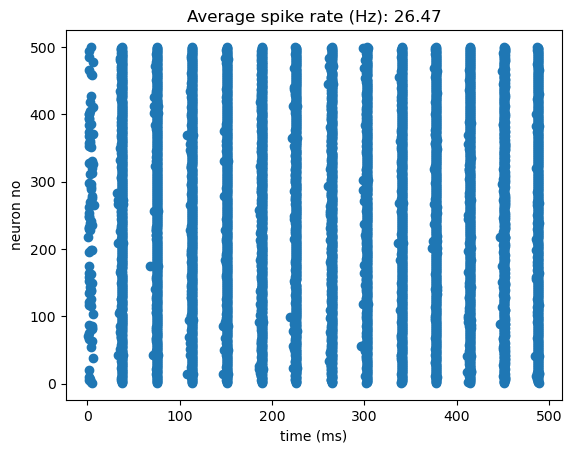

In [18]:
nest.Simulate(simtime)

events = sr.events
times = events["times"]
spikes = events["senders"]
n_spikes = sr.n_events

hz_rate = (1000.0 * n_spikes / simtime) / n_neuron

plt.figure(1)
plt.plot(times, spikes, "o")
plt.title(f"Average spike rate (Hz): {hz_rate:.2f}")
plt.xlabel("time (ms)")
plt.ylabel("neuron no")